In [11]:
# Your code here

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from utils import load_diabetes_db # from the utils.py file
from math import ceil
from pickle import dump

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import plot_tree
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, recall_score, balanced_accuracy_score

# Problem formulation

#### Predicting Diabetes
This dataset originally comes from the National Institute of Diabetes and Digestive and Kidney Diseases. The goal is to predict, based on diagnostic measures, whether or not a patient has diabetes.

# EDA

## Data fetching

This document works with data stored in a local database. To download the data please execute the utils.py script.

In [12]:
raw_df = load_diabetes_db()

## Data overview

| Feature Name | Description | 
| ----- | ----- | 
| **Pregnancies** | Number of pregnancies of the patient | 
| **Glucose** | Plasma glucose concentration 2 hours after an oral glucose tolerance test | 
| **BloodPressure** | Diastolic blood pressure (measured in mm Hg) | 
| **SkinThickness** | Triceps skin fold thickness (measured in mm) | 
| **Insulin** | 2-hour serum insulin (measured in mu U/ml) | 
| **BMI** | Body mass index | 
| **DiabetesPedigreeFunction** | Diabetes Pedigree Function | 
| **Age** | Age of patient | 
| **Outcome** | Class variable (0 or 1), being 0 negative in diabetes and 1 positive | 

In [13]:
raw_df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
index,,,,,,,,,
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0


In [14]:
raw_df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [15]:
raw_df.Outcome.sum()

np.int64(268)

In [16]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 60.0 KB


In [17]:
for column, data in raw_df.items():
    print(f'{column:15}: {(data==0).sum()}')

Pregnancies    : 111
Glucose        : 5
BloodPressure  : 35
SkinThickness  : 227
Insulin        : 374
BMI            : 11
DiabetesPedigreeFunction: 0
Age            : 0
Outcome        : 500


In [18]:
nduplicates = raw_df.duplicated().sum()
print(f'The data has {nduplicates} duplicates.')

The data has 0 duplicates.


## Overview analysis

- Some columns in the data contain a huge amount of 0 values that do not make sense. Those are just missing values.
- The columns affected by missing values are `BMI`, `Insulin`, `SkinThickness`, `BloodPressure` and `Glucose`.
- The dataset does not have duplicated rows.
- The dataset is rather small, which is not great for predictions so is better not to expect high accuracy measurements for our model.
- The dataset is unbalanced (only 35% of the samples present diabetes). 

## Initial data cleaning

- Since the columns `SkinThickness` and `Insulin` have so many missing values it is better to just drop those entire features.
- For the rest of the columns we can just drop the rows where those values are 0 since they have few missing values.

In [32]:
clean_df = raw_df.copy()
clean_df = clean_df[(clean_df.BloodPressure!=0) & (clean_df.Glucose!=0) & (clean_df.BMI!=0)]
clean_df.drop(['Insulin', 'SkinThickness'], axis=1, inplace=True)
clean_df.reset_index(inplace=True, drop=True)
print(f'new dataset shape: {clean_df.shape}')

new dataset shape: (724, 7)


In [34]:
for column, data in clean_df.items():
    print(f'{column:15}: {(data==0).sum()}')

Pregnancies    : 99
Glucose        : 0
BloodPressure  : 0
BMI            : 0
DiabetesPedigreeFunction: 0
Age            : 0
Outcome        : 475


## Univariate and multivariate analysis

### Figure 1

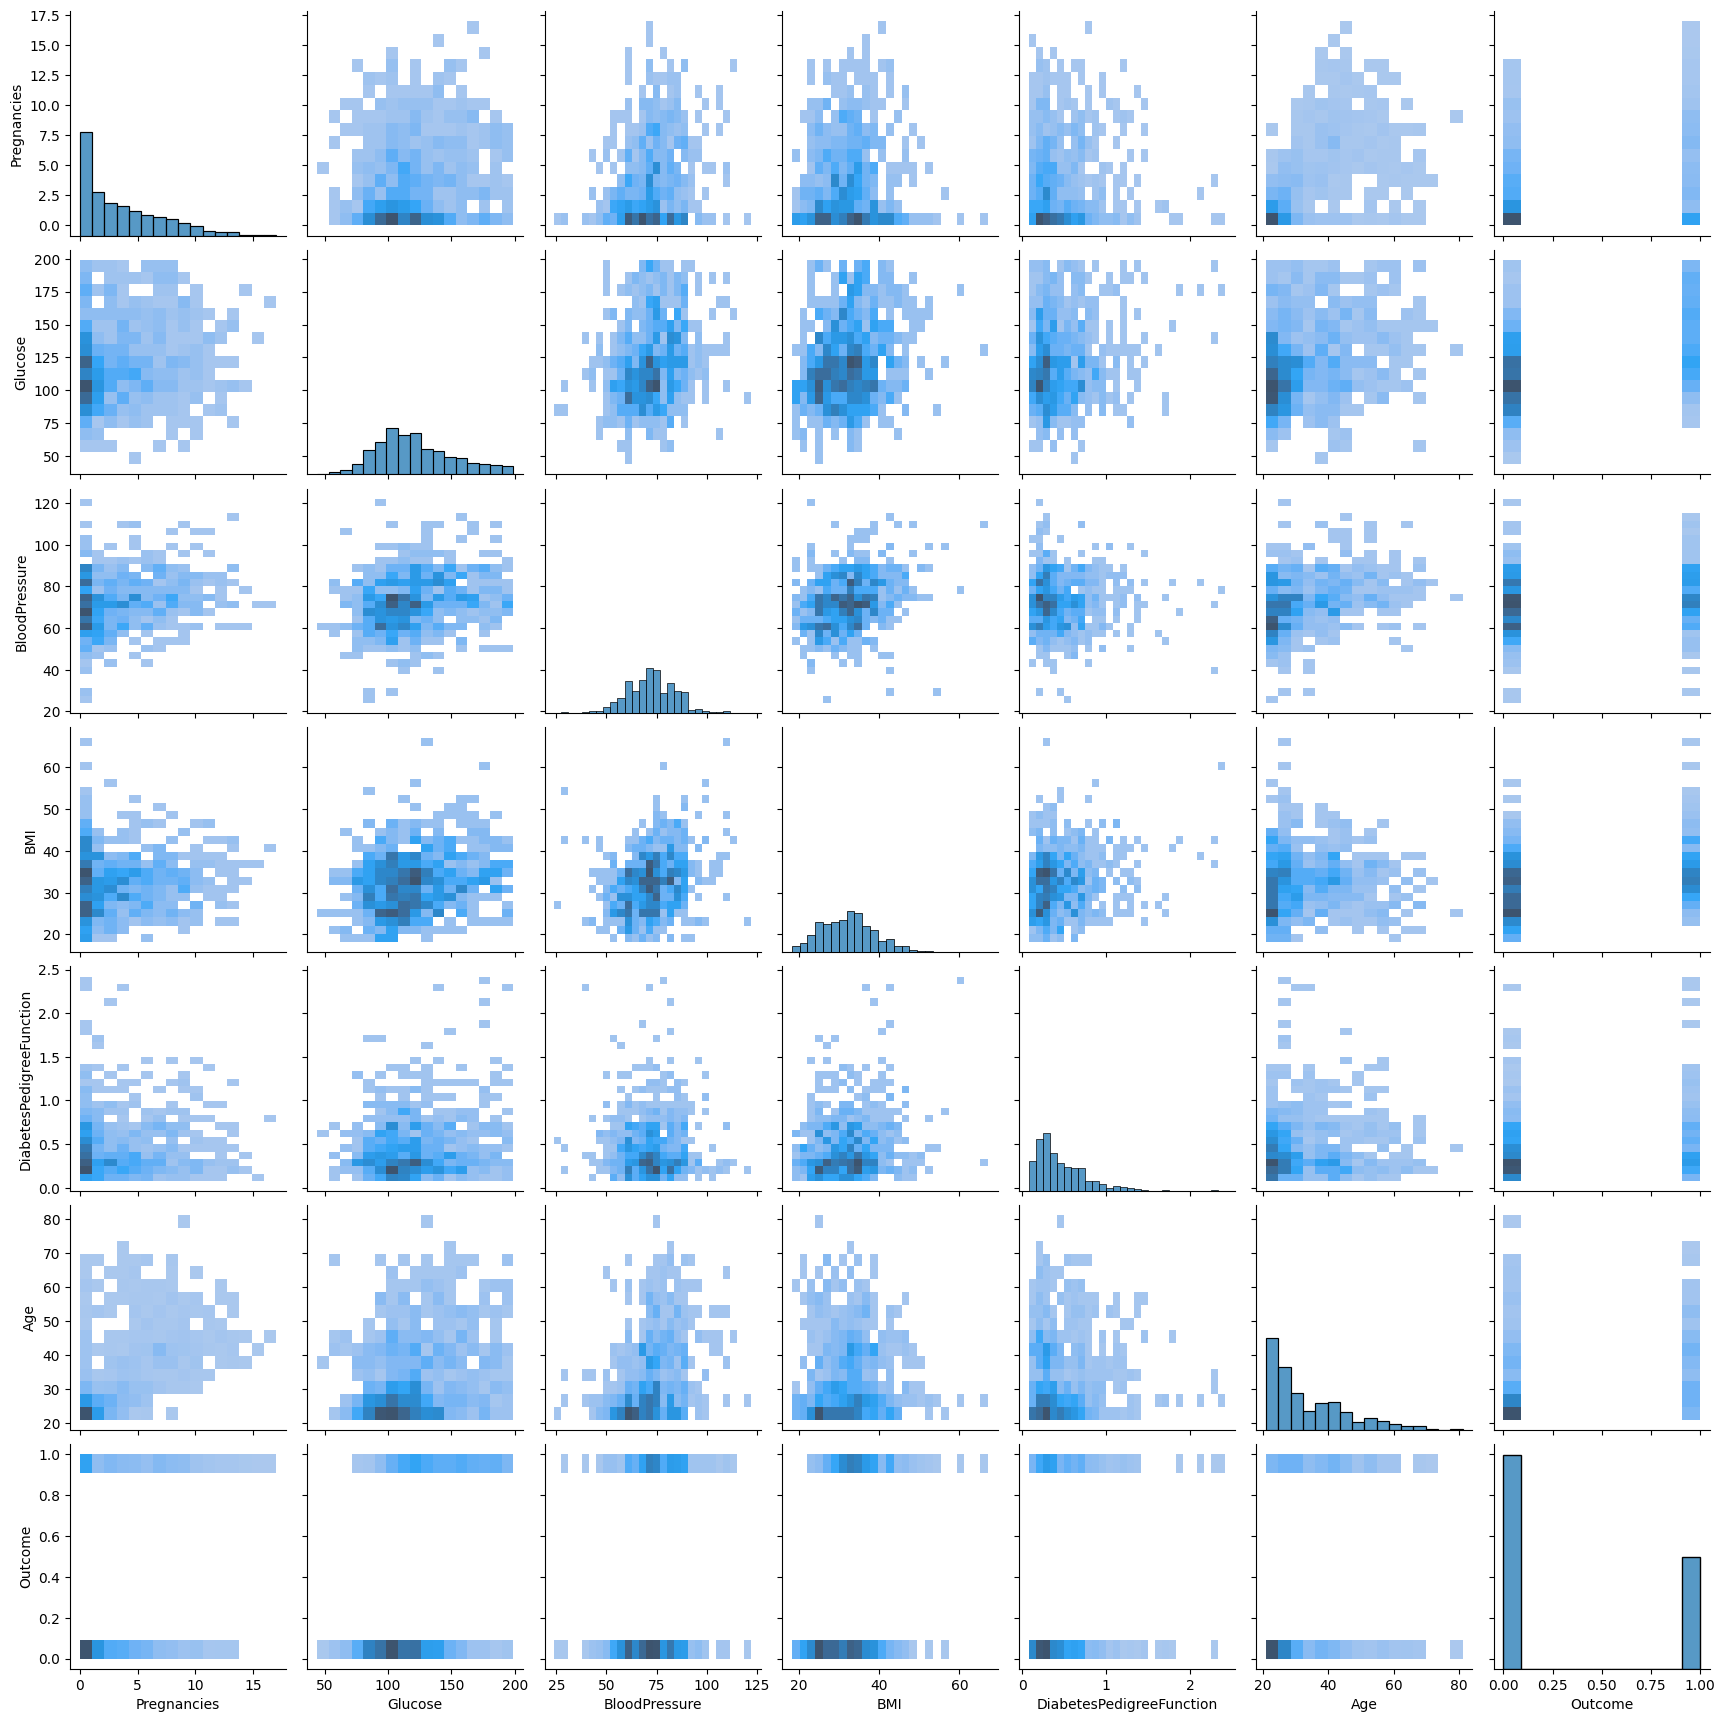

In [35]:
sns.pairplot(clean_df, kind='hist')
plt.show()

### Figure 2

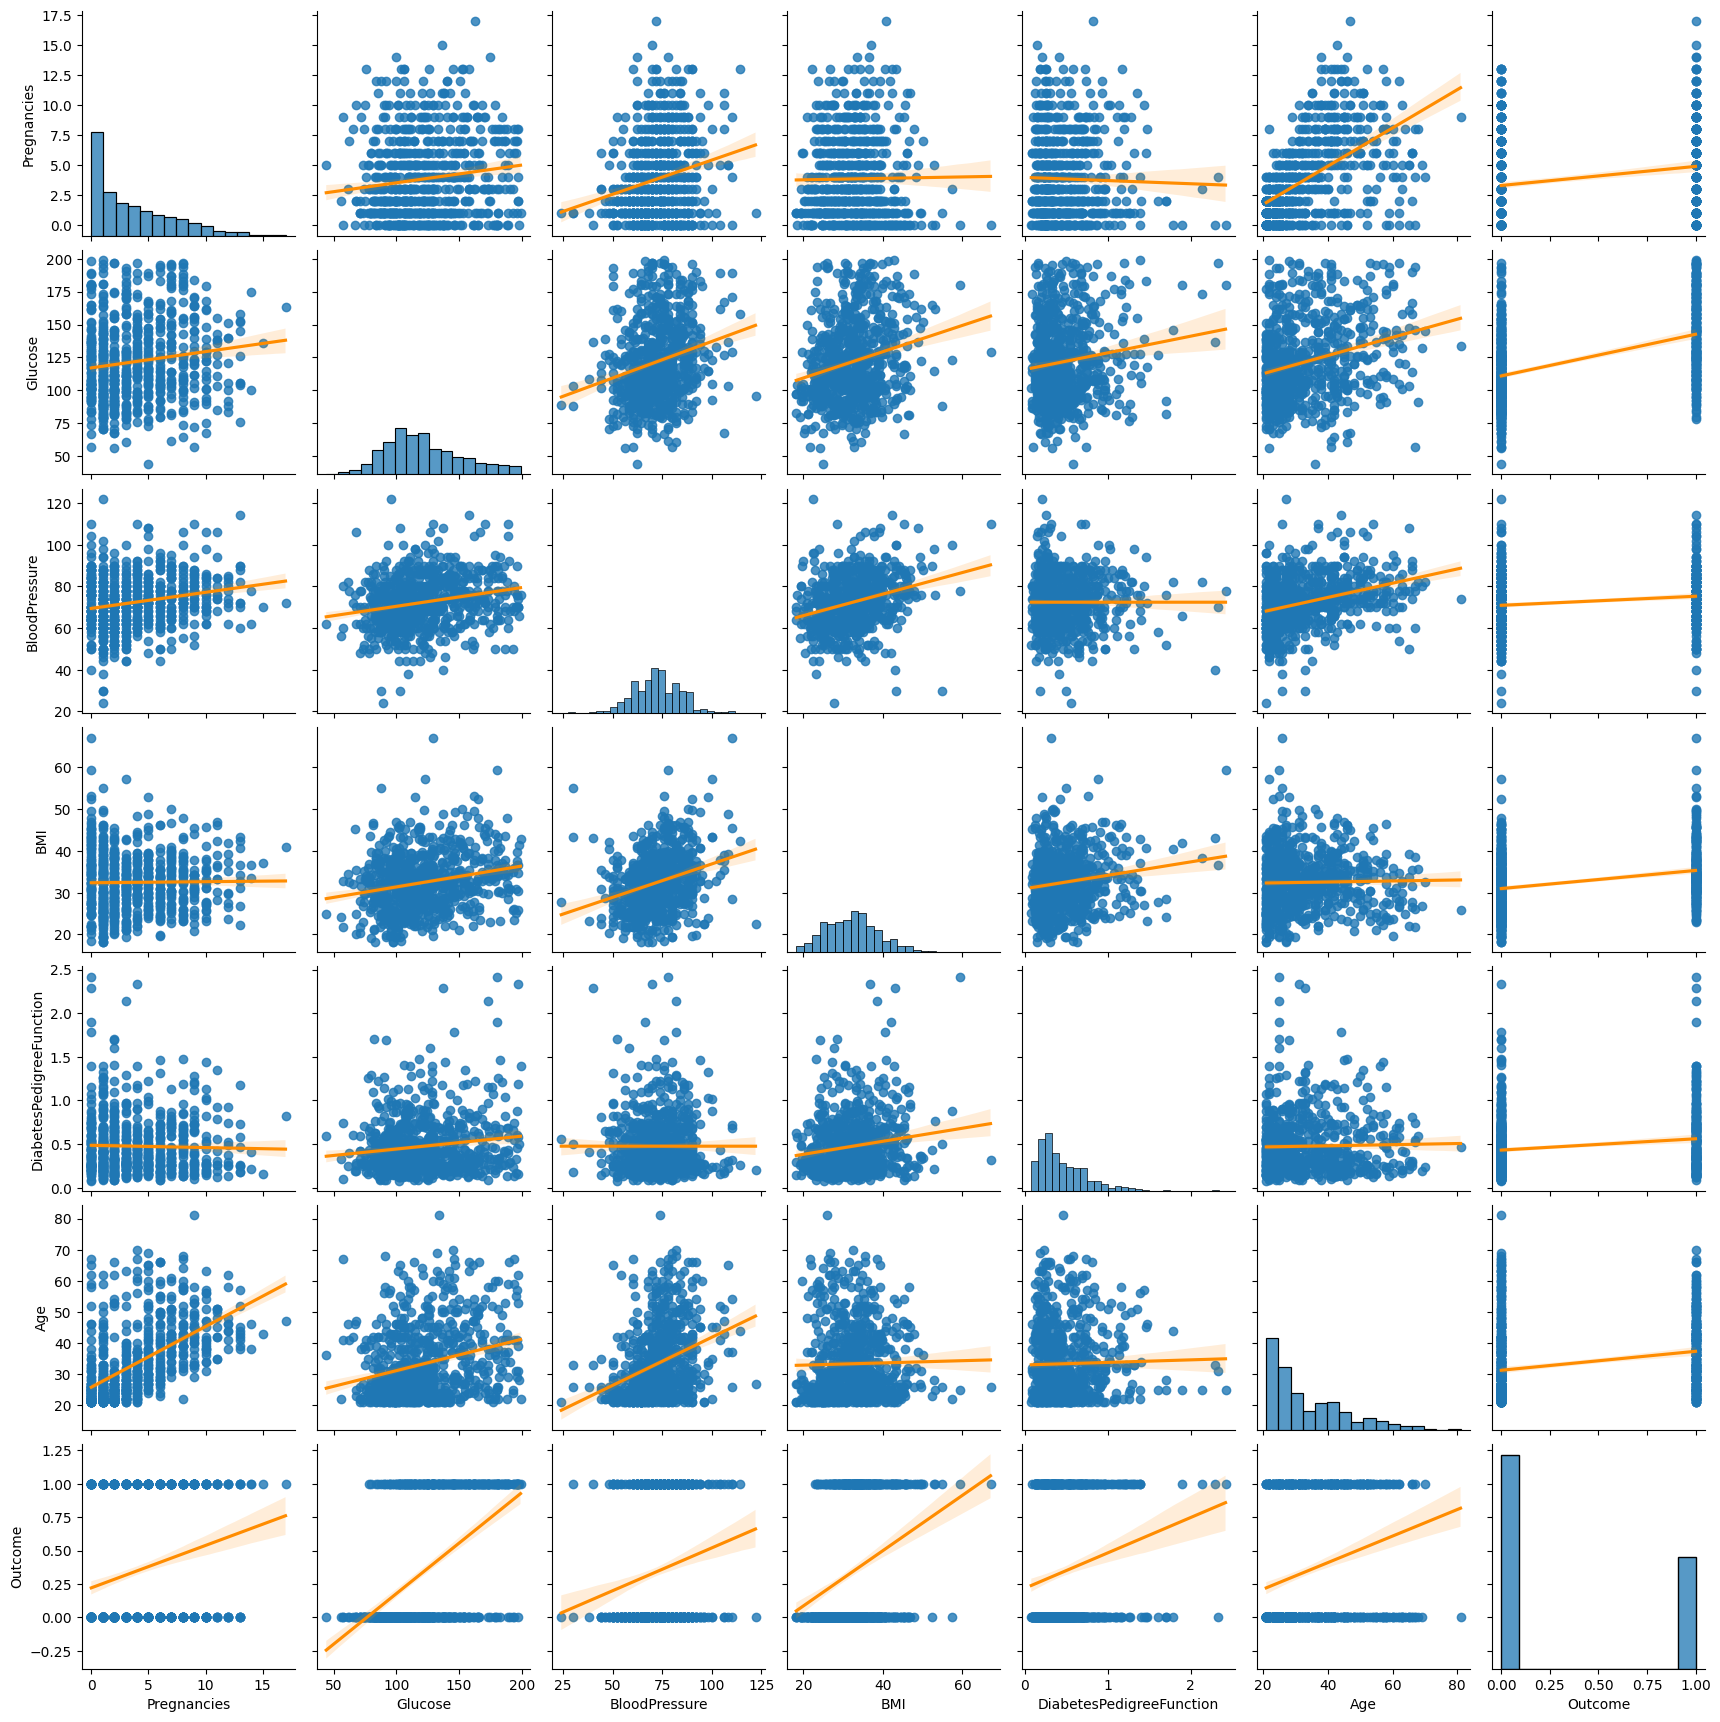

In [36]:
sns.pairplot(clean_df, kind='reg', plot_kws={'line_kws':{'color':'darkorange'}})
plt.show()

### Figure 3

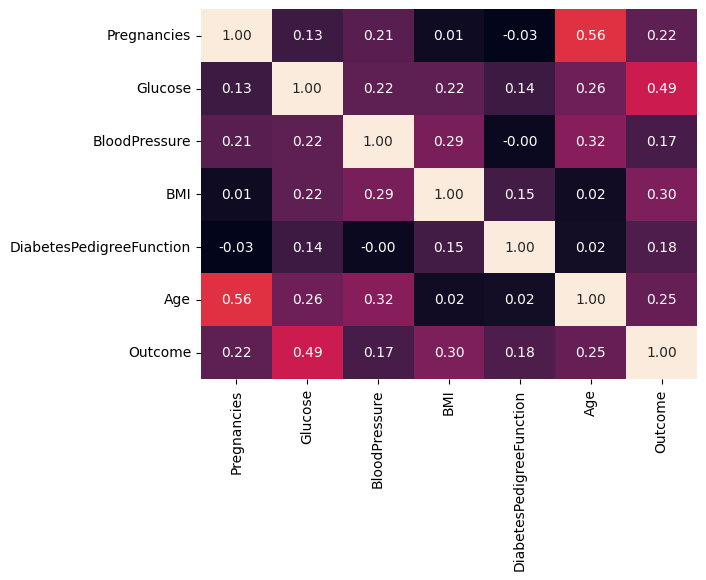

In [38]:
sns.heatmap(clean_df.corr(), annot=True, fmt='.2f', cbar=False)
plt.show()

### Figure 4

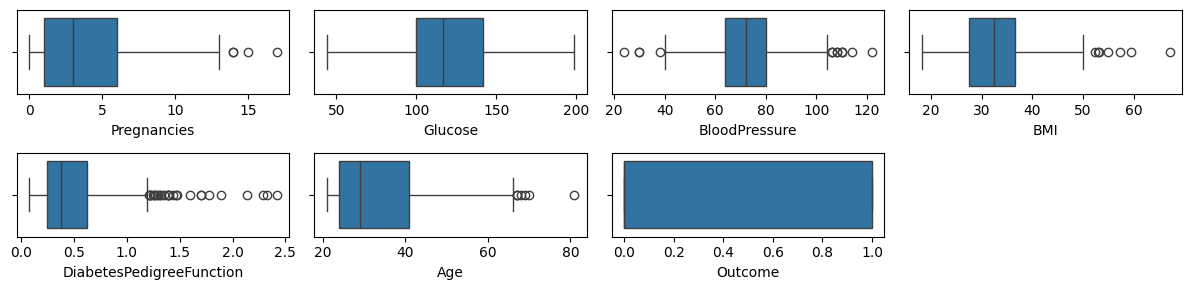

In [39]:
nplots = len(clean_df.columns)

ncols = 4
nrows = ceil(nplots/ncols)
sizein = 3

fig = plt.figure(figsize=(sizein*ncols, sizein*nrows*0.5))
ax=[]

for i, col in enumerate(clean_df.columns):
    new_plot = fig.add_subplot(nrows, ncols, i+1)
    ax.append(new_plot)
    
    sns.boxplot(clean_df, x=col, ax=ax[i])
    
plt.tight_layout()
plt.show()

### Plot conclusions
- It appears to be that all the values have usual.
- We can see in figures 3 and 2, that there is a positive correlation between all the variables ant diabetes.
- Although the outliers seem like normal, some values of blood pressure that seem like from people going into cardiac arrest (low blood pressure starts bellow 60, and some people in the dataset have values around 20 and 30). Since we do not know nothing about how the data was obtained we cannot discard the idea that those were real measured values. 

## Feature engineering

- There are not meaningful new features that we can create from this dataset.

# Model creation

Given some of the characteristics of the data it is appropriate to use a model based on decision trees, in this case we will use the XGBoost algorithm.

## Initial model

In [33]:
x = clean_df.drop(['Outcome'], axis=1)
y = clean_df.Outcome

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42, test_size=0.2)

model = XGBClassifier(random_state = 42)
model.fit(x_train, y_train)

y_predict = model.predict(x_test)
acc_score = accuracy_score(y_test, y_predict)
rec_score = recall_score(y_test, y_predict)
bal_score = balanced_accuracy_score(y_test, y_predict)

print(f'accuracy = {acc_score}')
print(f'recall = {rec_score}')
print(f'balanced accuracy score = {bal_score}')


accuracy = 0.7862068965517242
recall = 0.6976744186046512
balanced accuracy score = 0.7606019151846786


## Hyper parameter tunning.

- Since the dataset is imbalanced, for the grid search we will use the average precision scoring.

In [22]:
parameters = {
    'n_estimators': [50,100,200],
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': [5,20],
    'min_samples_split': [2,5,10],
    'min_samples_leaf': [1,3,8,12]
}
grid = GridSearchCV(model, parameters, scoring='average_precision', cv=5, n_jobs=-1)
grid.fit(x_train, y_train)
tunned_model = grid.best_estimator_

y_predict = tunned_model.predict(x_test)
acc_score = accuracy_score(y_test, y_predict)
rec_score = recall_score(y_test, y_predict)
bal_score = balanced_accuracy_score(y_test, y_predict)

print(grid.best_params_)
print(f'accuracy = {acc_score}')
print(f'recall = {rec_score}')
print(f'balanced accuracy score = {bal_score}')


KeyboardInterrupt: 

### Figure 6 
just some of the trees of the model

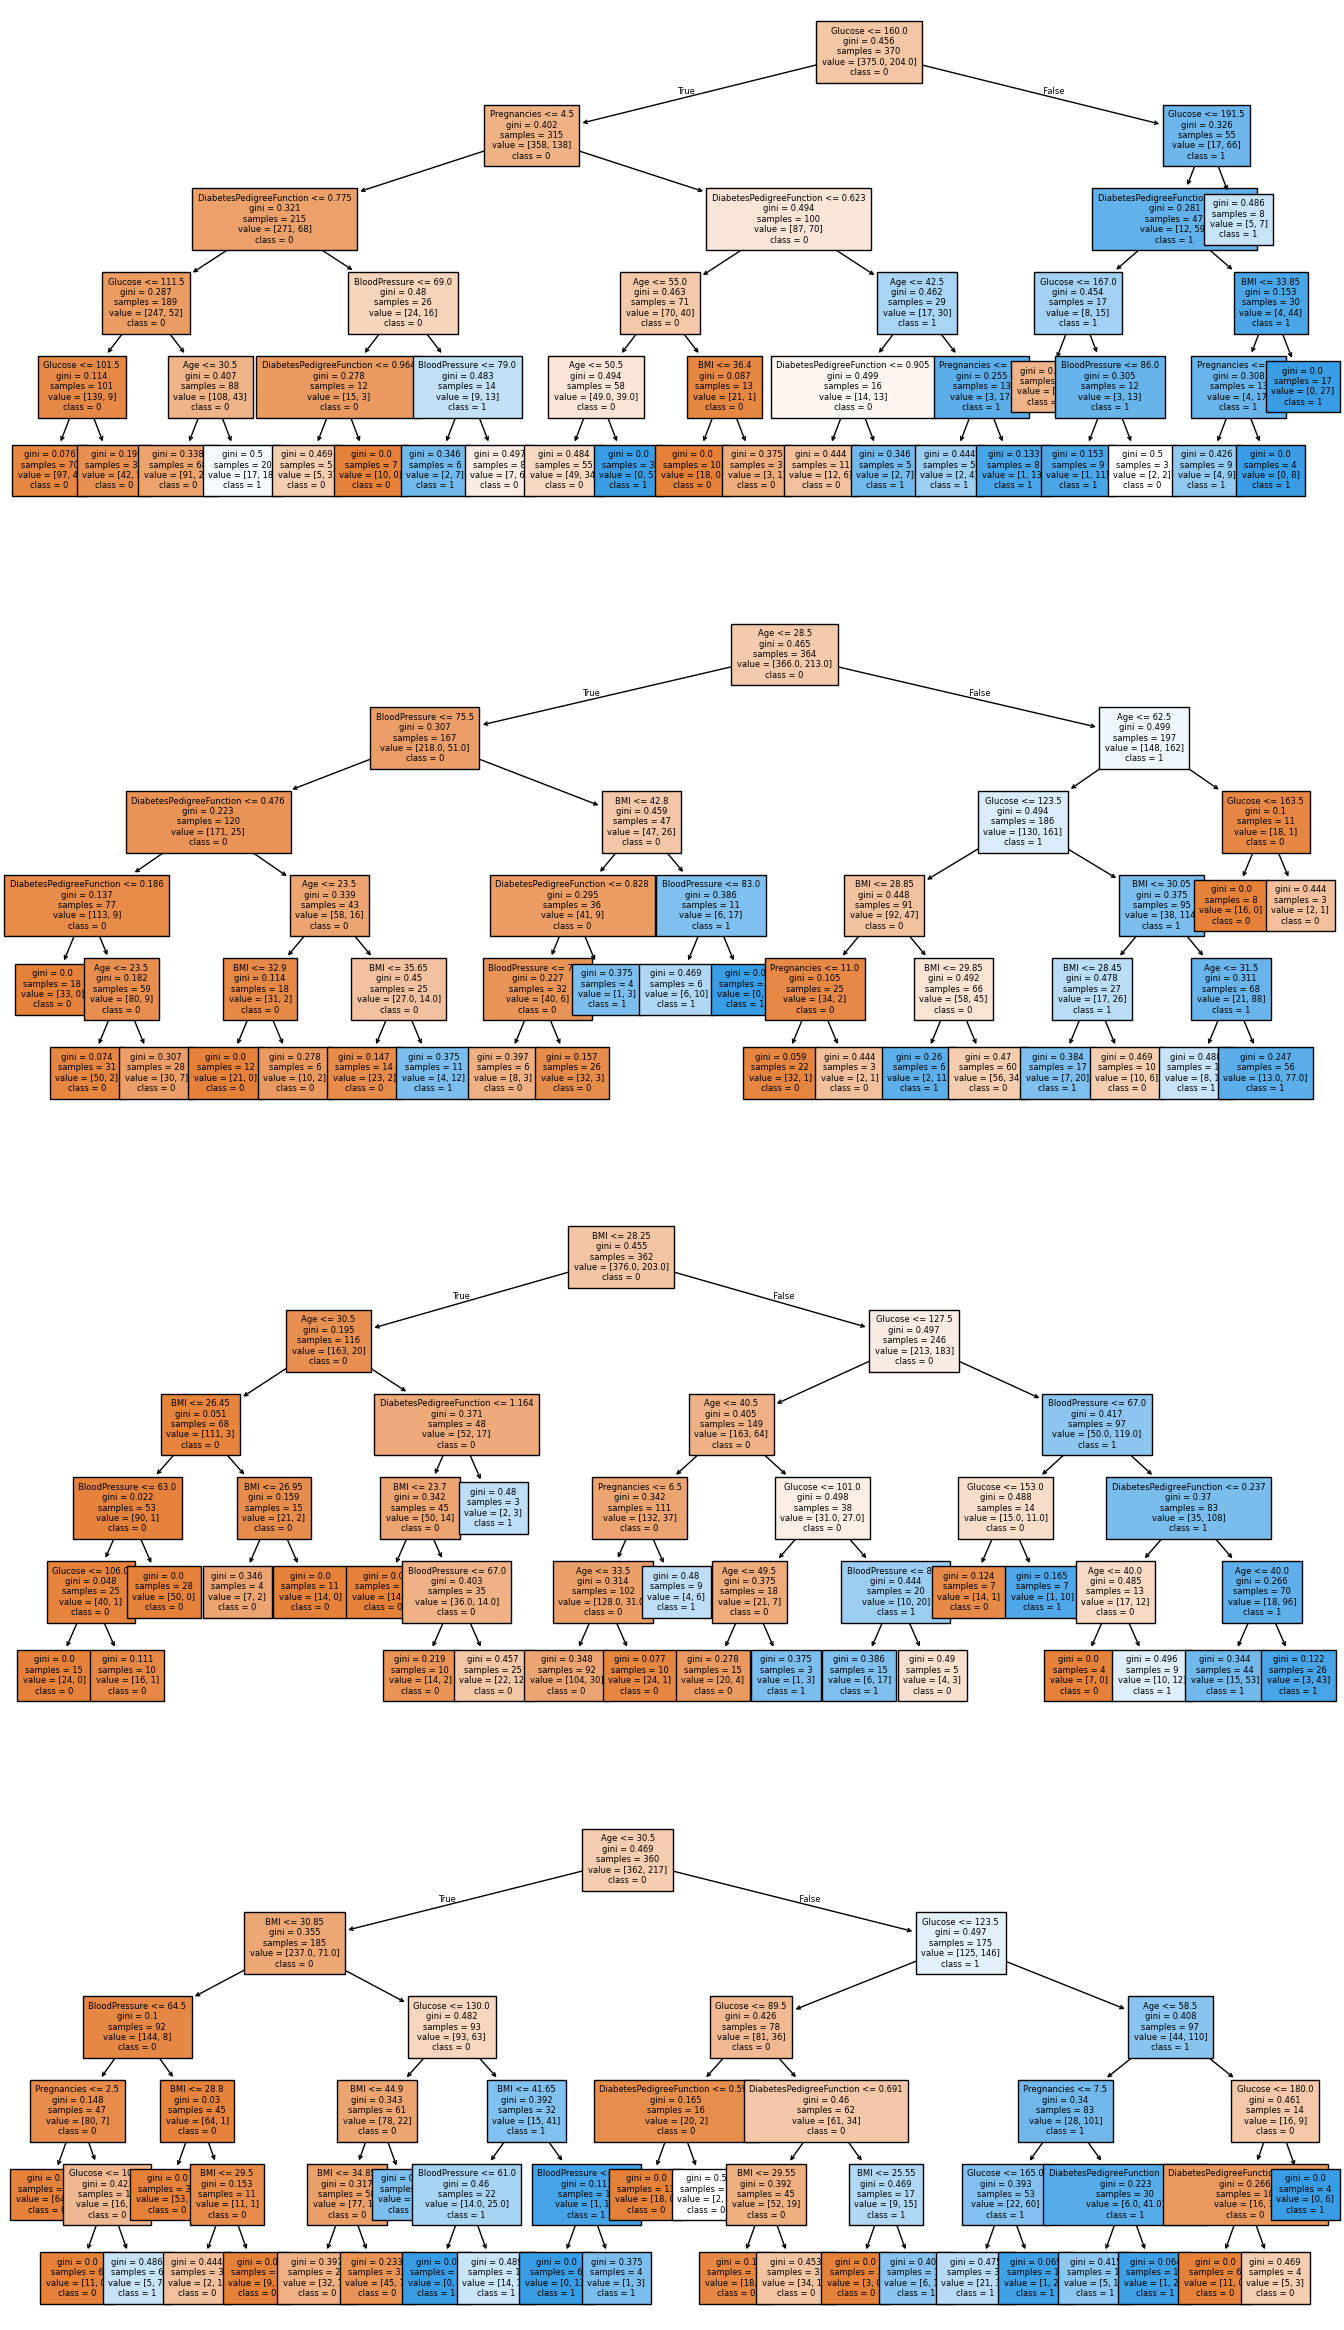

In [48]:
fig, axis = plt.subplots(4, figsize = (17, 30))

# We show the first 4 trees out of the 100 generated (default)
plot_tree(tunned_model.estimators_[0], ax = axis[0], fontsize=6, class_names = ["0", "1"], feature_names = list(x.columns), filled = True)
plot_tree(tunned_model.estimators_[1], ax = axis[1], fontsize=6, class_names = ["0", "1"], feature_names = list(x.columns), filled = True)
plot_tree(tunned_model.estimators_[2], ax = axis[2], fontsize=6, class_names = ["0", "1"], feature_names = list(x.columns), filled = True)
plot_tree(tunned_model.estimators_[3], ax = axis[3], fontsize=6, class_names = ["0", "1"], feature_names = list(x.columns), filled = True)

plt.show()

# Conclusions
- We got an accuracy score of 82% for our final model, which for our case is acceptable, but the true positive rate falls a bit short of 70% which is not a good measure. This means our model is somewhat decent at telling if someone does not has diabetes but is not so great telling apart the people who has this condition.
- I couldn't improve at all the true positive rate of the model using the grid search cross validation method, this might have been caused by one or more of the next causes:
    1. An insufficient amount of data on people with diabetes (we only have around 250 samples of people with the condition).
    2. The random forest model is not the most adequate for predicting diabetes in this dataset.
    3. I committed a mistake during the data cleaning.
    4. Not enough grid parameters were tested. 
- This time it was useful to get rid of the variables with a lot of missing data (This was tested using different grids), this suggest that those variables (`SkinThickness` and `Insulin`) where too noisy and their values where missing at random.
- There is a chance that the missing values actually had some correlation with other variables but if we take into account that all the variables had some positive correlation with our target we will realize that chance is very slim.
- Another point that suggests that we need mor data for a realistic model is that the latest International Diabetes Federation Atlas report founded that the diabetes prevalence in the world is of 11.1% while the prevalence in our sample is of 35%, more than three times as much. We cannot discard though that maybe the sample was taken in a population with higher rates of diabetes at the time of the gathering of the data (this time is unknown) like pakistan in 2025 for instance (30.8% prevalence according to the www.worldpopulationreview.com diabetes ranking 2025).

# saving the model

In [50]:
model_name_placeholder = (
    'random_forest_classifier_'
    'estimators_{n_estimators}_'
    '{criterion}'
    '_maxdepth_{max_depth}'
    '_minsamplessplit_{min_samples_split}_'
    'minsamplesleaf_{min_samples_leaf}'
    '_randomstate_42')
model_name = model_name_placeholder.format(**grid.best_params_)
path = '../models/' + model_name + '.sav'
dump(tunned_model, open(path, 'wb'))